# Boosting与AdaBoost，Bagging与RF，GBDT与XGBoost

1) Hoeffding不等式证明错误率上界，为集成学习提供理论保证：$P(G(x) \neq y_i) = \sum_{m=0}^{M/2}\binom{M}{m}(1-\varepsilon )^m\varepsilon ^{M-m} \leqslant  e^{-\frac{1}{2}M(1-2\varepsilon)^2}$，T越多，错误率成指数下降；前提是基学习器误差独立（通常很难办到，基学习器解决同一问题）

2） Boost中AdaBoost：加性模型，以指数损失函数（求导可以得到每个学习器权重，并由此更新样本权重）；对异常样本比较敏感，影响效率（本质是是对错误样本加权（如果不支持加权，则采用重采样），再训练新学习器，降低偏差）

模型权重$\alpha_m=\frac{1}{2}log_e\frac{1 - e_m}{e_m}$,样本权重：$w_{m+1,i}=\frac{w_{mi} \cdot e^{-\alpha_m * y_i * G_m(x_i)}}{z_m},z_m = \sum_{i=1}^{N}w_{mi} e^{-\alpha_m \cdot y_i \cdot G_m(x_i)}$

通常只做分类问题，做回归问题需要做较大的改造（TODO）

3）Bagging与RF：增加基学习器多样性从样本多样性开始（重采样：自助法：放回采样，m次采样：$\lim_{x \rightarrow \infty }(1-\frac{1}{m})^{m}=\frac{1}{e}\approx 0.368$,所以，每次都有36.8%的数据不会被采到，用$D/{D}'$作为测试集；**缺点**自助法产生的数据集改变了初始数据集的分布，只在**样本较少情况**下使用），有2大优势，一方面可以做包外估计，另一方面，如果基分类器为决策树，还可以用于剪枝（但是一般用决策树桩）

Bagging方法选择不同的基分类器，可以做分类/多分类也可以做回归

RF：多了属性多样性:当前属性随机选k个（推荐$k=log_2d$），根据划分算法选择最优属性

Bagging系列算法专注降低方差。泛化能力更强。训练效率也更高（随机选择属性）

结合策略，通常是简单平均，多数投票，训练法(MLR @todo)

4） GBDT：基分类器CART回归树，核心是证明在分类回归任务时，伪残差的计算，以及分类任务在树完成后更新残差时使用泰勒展开，代替近似的残差（分类问题在CART回归树不能使用简单平均法去求为残差了）

5） XGBoost：gbdt的实现，优化点在于使用泰勒展开obj，不仅可以提高速度（二阶导在SGD中相当于学习率，动态更新学习率），还可以扩展可用损失函数（二阶可导凸函数）。加入正则化因子（相当于预剪枝），引入列block机制进行特征粒度并行，以及核外计算，缓存预取等提高效率的实现（具体参看论文系统设计一节）

## 内部多样性度量
学习器比较的时候可以使用
参考周志华《机器学习》

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [166]:
# 西瓜数据测试：不使用测试集了
dt = xgb.DMatrix('wm_data.csv')
print("行/列:", dt.num_row(),dt.num_col())
# eta: 学习步长,silent:打印运行信息，objective：二分类逻辑回归
param = {'max_depth':1, 'eta':0.9, 'silent':0, 'objective':'binary:logistic' }
print("参数：", param)

行/列: 17 8
参数： {'max_depth': 1, 'eta': 0.9, 'silent': 0, 'objective': 'binary:logistic'}


In [167]:
# 训练：设置boosting迭代计算次数
num_round = 10
bst = xgb.train(param, dt, num_round) 

[11:07:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [168]:
# 准确率
pred_train_raw = bst.predict(dt)
for i in range(len(pred_train_raw)):
    if pred_train_raw[i] > 0.5:
         pred_train_raw[i]=1
    else:
        pred_train_raw[i]=0               
print (accuracy_score(dt.get_label(), pred_train_raw))

0.8823529411764706


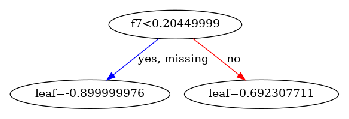

In [169]:
xgb.plot_tree(bst)

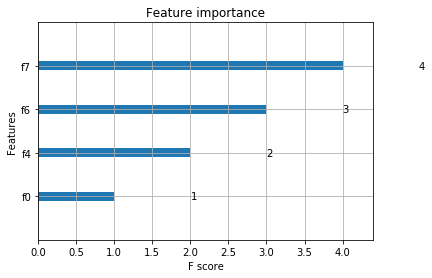

In [170]:
xgb.plot_importance(bst)

In [172]:
# 输出每个样本在所有树中的叶子节点
ypred_leaf = bst.predict(dt, pred_leaf=True)
print(ypred_leaf)

[[2 2 2 2 2 2 2 2 1 1]
 [2 2 2 2 2 1 2 2 1 1]
 [2 2 2 2 2 1 2 1 1 1]
 [2 2 2 2 2 2 2 1 1 1]
 [2 2 2 2 2 2 1 1 1 1]
 [2 1 2 1 2 2 1 1 2 2]
 [1 2 1 2 1 1 1 1 2 2]
 [2 2 2 1 2 1 1 1 2 2]
 [1 2 1 2 1 1 1 2 2 2]
 [2 1 2 1 2 2 2 1 2 1]
 [1 1 1 1 1 2 1 1 2 1]
 [1 1 1 1 1 2 1 1 2 1]
 [1 2 1 2 1 2 1 2 1 1]
 [1 2 1 2 1 2 1 2 1 1]
 [2 1 2 1 2 1 2 1 2 2]
 [1 2 1 2 1 2 1 1 2 1]
 [1 2 1 2 1 2 1 2 2 2]]


In [176]:
# 每个样本在xgboost生成的所有树中叶子节点的累加值,如logloss，是predict的无参数概率值累加
ypred_output = bst.predict(dt, output_margin=True)
print(ypred_output)
# 如果gbdt+lr，可以使用每颗树每个节点输出值为输入，再训练一颗LR

[ 1.1154481   1.57439     1.9936188   1.5346769   1.9330891   0.31610084
 -0.71638966  1.777998   -1.1356183  -0.4288945  -3.01441    -3.01441
 -1.4700669  -1.4700669   0.37663046 -1.5219144  -1.59456   ]


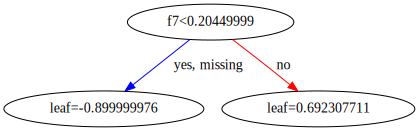

In [175]:
xgb.to_graphviz(bst)

In [33]:
from sklearn.model_selection import GridSearchCV

In [69]:
df.columns

Index(['color', 'root', 'knock', 'texture', 'umbilical', 'touch', 'density',
       'sugar_rate', 'label'],
      dtype='object')

In [102]:
df = pd.read_csv("wm_data_o.csv", sep=',', index_col=0)
X=df[['color', 'root', 'knock', 'texture', 'umbilical', 'touch', 'density',
       'sugar_rate']]
df

,color,root,knock,texture,umbilical,touch,density,sugar_rate,label
1,3.0,3.0,2.0,2.0,1.0,1.0,0.697,0.460,1.0
2,1.0,3.0,1.0,2.0,1.0,1.0,0.774,0.376,1.0
3,1.0,3.0,2.0,2.0,1.0,1.0,0.634,0.264,1.0
4,3.0,3.0,1.0,2.0,1.0,1.0,0.608,0.318,1.0
5,2.0,3.0,2.0,2.0,1.0,1.0,0.556,0.215,1.0
6,3.0,2.0,2.0,2.0,3.0,2.0,0.403,0.237,1.0
7,1.0,2.0,2.0,3.0,3.0,2.0,0.481,0.149,1.0
8,1.0,2.0,2.0,2.0,3.0,1.0,0.437,0.211,1.0
9,1.0,2.0,1.0,3.0,3.0,1.0,0.666,0.091,0.0
10,3.0,1.0,3.0,2.0,2.0,2.0,0.243,0.267,0.0


In [178]:
# 保存model，以备CPP工程化
bst.dump_model('xgb.dump.raw.txt')

In [101]:
# 自动调参示例
param_test1 = {'eta':[i/10.0 for i in range(0,10,1)]}

param_dist = {'objective':'binary:logistic', 'n_estimators':5, "max_depth":2}


gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**param_dist), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X, dt.get_label())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=5, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, vali

In [99]:
gsearch1.best_params_,gsearch1.best_score_

({'eta': 0.1}, 0.6)

In [146]:
# 用sklearn接口
# X为样本特征，y为样本类别输出， 共10000个样本，每个样本20个特征，输出有2个类别，没有冗余特征，每个类别一个簇
X, y = make_classification(n_samples=10000, n_features=20, n_redundant=0,
                             n_clusters_per_class=1, n_classes=2, flip_y=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
param = {'max_depth':5, 'eta':0.1, 'verbosity':1, 'objective':'binary:logistic'}
xgb_model = xgb.train(param, dtrain, num_boost_round=10)


In [147]:
# 输出所有样例正负概率
y_test_score = xgb_model.predict(xgb.DMatrix(X_test))
y_test_label = y_test

In [148]:
# 画roc曲线
def cal_roc(y_test, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test[:,:].ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr,tpr,roc_auc
fpr,tpr,roc_auc = cal_roc(y_test.reshape(len(y_test),1), y_test_score.reshape(len(y_test_score),1), 1)

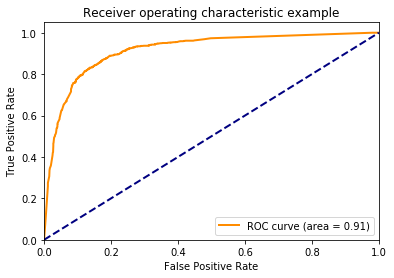

In [149]:
plt.figure()
label_idx = 0
lw = 2
plt.plot(fpr[label_idx], tpr[label_idx], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label_idx])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()